In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, mean_squared_error
from implicit import als
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
df = pd.read_csv('data/combined_data.csv')

In [3]:
df.head()

,user,Title,Rating,Review URL,Liked
0,000_leo,Mufasa: The Lion King,1.5,NaN,False
1,000_leo,The Six Triple Eight,2.0,NaN,False
2,000_leo,Cunk on Life,3.5,NaN,False
3,000_leo,Carry-On,3.0,NaN,False
4,000_leo,Nosferatu,3.0,NaN,False


In [4]:
num_unique_users = len(set(df['user']))
num_unique_movies = len(set(df['Title']))
num_ratings = len(df) - sum(df['Rating'].isna())
num_likes = sum(df['Liked'])

print("number of unique users:", num_unique_users)
print("number of unique movies:", num_unique_movies)
print("number of ratings:", num_ratings)
print("number of likes:", num_likes)

number of unique users: 2496
number of unique movies: 235227
number of ratings: 5407086
number of likes: 2140392


There are only 2496 unique users because 4 of the top 2500 users hadn't logged any films at the time of scraping (week of January 13, 2025).

C:\Users\sarah\AppData\Local\Temp\ipykernel_14104\180309627.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='Blues')


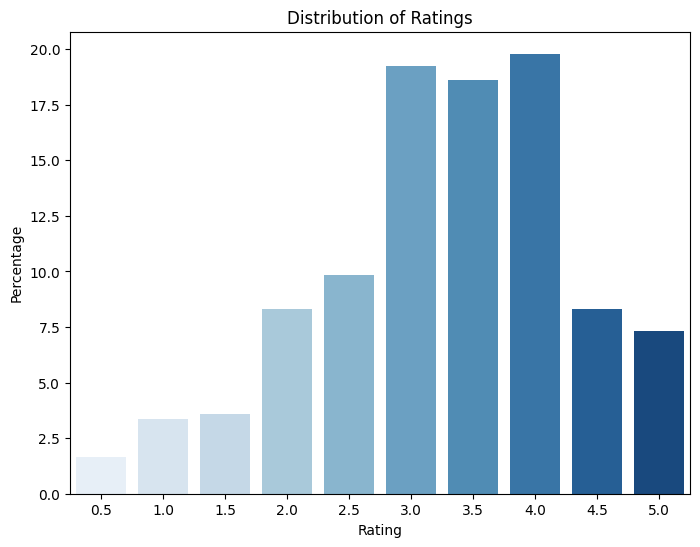

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting rating distribution
plt.figure(figsize=(8,6))

# Calculate percentage
rating_counts = df['Rating'].value_counts(normalize=True) * 100  # Normalize to get percentage
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='Blues')

# Adding labels and title
plt.xlabel('Rating')
plt.ylabel('Percentage')
plt.title('Distribution of Ratings')

# Show the plot
plt.show()

C:\Users\sarah\AppData\Local\Temp\ipykernel_14104\984494158.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='Blues')


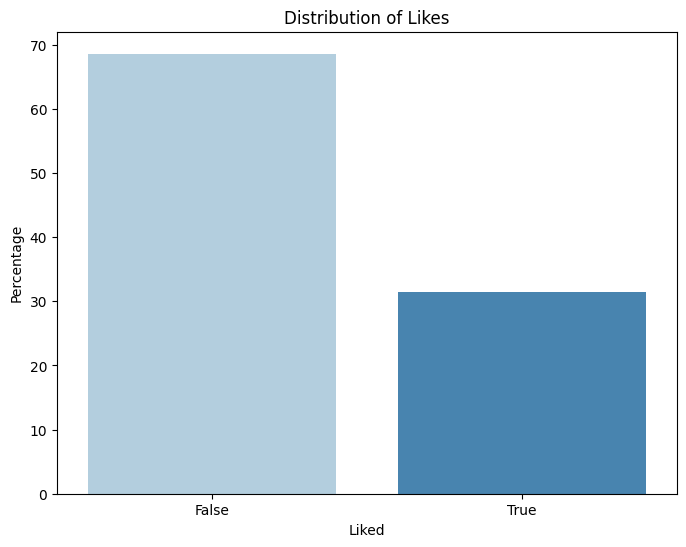

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting rating distribution
plt.figure(figsize=(8,6))

# Calculate percentage
rating_counts = df['Liked'].value_counts(normalize=True) * 100  # Normalize to get percentage
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='Blues')

# Adding labels and title
plt.xlabel('Liked')
plt.ylabel('Percentage')
plt.title('Distribution of Likes')

# Show the plot
plt.show()

Ratings distribution shows left/negative skew. Roughly a third of films were "liked." Will create an "enjoyed" indicator that is true if a user rates a film >= 4 stars OR likes it. This will serve to combine likes and ratings into one decisive attribute.

In [7]:
# Create aggregated user-level features
user_features = df.groupby('user').agg(
    average_rating=('Rating', 'mean'),
    rating_deviation=('Rating', 'std'),
    num_ratings=('Rating', 'count'),
    num_liked_movies=('Liked', 'sum')
)

# Add total number of movies
user_features['total_movies'] = df.groupby('user')['Title'].apply(lambda x: x.notna().sum())

# Calculate percent rated, avoid division by zero
user_features['percent_rated'] = user_features['num_ratings'] / user_features['total_movies']
user_features['percent_rated'] = user_features['percent_rated'].fillna(0)  # Fill NaN if no ratings

user_features['percent_liked'] = user_features['num_liked_movies'] / user_features['total_movies']
user_features['percent_liked'] = user_features['percent_liked'].fillna(0)  # Fill NaN if no likes

In [8]:
user_features

,average_rating,rating_deviation,num_ratings,num_liked_movies,total_movies,percent_rated,percent_liked
user,,,,,,,
000_leo,2.895613,0.748025,661,215,2782,0.237599,0.077283
007filmreviwer,3.242786,1.137534,3396,2427,3401,0.998530,0.713614
14ltobias,3.037292,1.159730,2105,392,2417,0.870914,0.162185
15stepper,3.526943,1.269656,1930,665,1983,0.973273,0.335350
19thlvlcleric,3.585258,0.860654,1126,576,1493,0.754186,0.385800
...,...,...,...,...,...,...,...
zrshelton,2.774691,1.247399,1944,784,2172,0.895028,0.360958
zshevich,3.082957,0.825518,3984,366,4103,0.970997,0.089203
zuzupan,2.349569,1.230543,1160,154,2545,0.455796,0.060511
